In [17]:
import requests
import zipfile
import io
import os
import yaml
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import time

def generate_data(yamlFile):
    '''
    generate data and return csv names
    '''
    
    url = "http://oasis.caiso.com/oasisapi/SingleZip"
    extract_directory = ""
    csv_list = []
    start_time = yamlFile["start_time"]
    end_time = yamlFile["end_time"]
    forecast_type = yamlFile["forecast_type"]
    market_run_id = yamlFile["market_run_id"]
    execution_type = yamlFile["execution_type"]
    csv_name = f"{start_time}_{end_time}_{forecast_type}_{market_run_id}_{execution_type}.csv"
    csv_name = os.path.join("data", csv_name)
    start_time = datetime.strptime(start_time, "%Y%m%dT%H:%M%z")
    end_time = datetime.strptime(end_time, "%Y%m%dT%H:%M%z")
    merged_data = pd.DataFrame()

    if  not os.path.exists(csv_name):
        while end_time > start_time:
            def request(start_time, end_time):
                params = {
                    "resultformat": "6",
                    "queryname": forecast_type,
                    "market_run_id": market_run_id,
                    "execution_type": execution_type,
                    "version": "1",
                    "startdatetime": start_time.strftime('%Y%m%dT%H:%M%z').replace("+","-"),
                    "enddatetime": min(start_time + timedelta(days=30), end_time).strftime('%Y%m%dT%H:%M%z').replace("+","-")
                }

                response = requests.get(url, params=params)
                while response.status_code == 429:
                    time.sleep(1)
                    response = request(start_time, end_time)
                return response

            response=request(start_time, end_time)
            if response.status_code == 200:
                data = response.content
                zip_data = io.BytesIO(data)
                csv = None
                with zipfile.ZipFile(zip_data, 'r') as zip_ref:
                    file_bytes = zip_ref.read(zip_ref.namelist()[0])
                    merged_data = pd.concat([merged_data, pd.read_csv(io.BytesIO(file_bytes))], ignore_index=True)
            else:
                print("Request failed with status code:", response.status_code)
            
            start_time += timedelta(days=30)
            time.sleep(1)
            
        merged_data.to_csv(csv_name, index=False)
    return csv_name

In [18]:
def split_data(csv, yamlFile):
  '''
  split data from one csv to specific dataset
  '''
  
  data = pd.read_csv(csv)

  # print(data.shape)

  zone_id = yamlFile["zone_id"]
  training_set_start = yamlFile["training_set_start"]
  training_set_end = yamlFile["training_set_end"]
  validation_set_start = yamlFile["validation_set_start"]
  validation_set_end = yamlFile["validation_set_end"]
  RENEWABLE_TYPE = yamlFile["RENEWABLE_TYPE"]
  zone_id = yamlFile["zone_id"]
  training_set = data.query(f'OPR_DT <= "{training_set_end}" and OPR_DT >= "{training_set_start}" and TRADING_HUB == "{zone_id}" and RENEWABLE_TYPE == "{RENEWABLE_TYPE}"')
  validation_set = data.query(f'OPR_DT <= "{validation_set_end}" and OPR_DT >= "{validation_set_start}" and TRADING_HUB == "{zone_id}" and RENEWABLE_TYPE == "{RENEWABLE_TYPE}"')  
  training_set.loc[:, 'training_type'] = 'training'
  validation_set.loc[:, 'training_type'] = 'validation'
  
  return training_set, validation_set

In [19]:
def limit_display(num_ticks):
  """
  limit display number of x data points
  """
  ax = plt.gca()
  x_ticks = ax.get_xticks()
  x_labels = ax.get_xticklabels()
  step = len(x_ticks) // num_ticks
  ax.set_xticks(x_ticks[::step])
  ax.set_xticklabels(x_labels[::step])
  plt.show()
  
  
def visualization(yamlFile):
  ''' 
  visualize for certain data
  '''
  csv = generate_data(yamlFile)
  training_set, validation_set = split_data(csv, yamlFile)
  wholedata = pd.concat([training_set, validation_set])
  wholedata = wholedata.sort_values(by="INTERVALSTARTTIME_GMT")
  plot = sns.relplot(data=wholedata, x="INTERVALSTARTTIME_GMT", y="MW", hue="training_type", kind="line", height=4, aspect=4)
  label = yamlFile['market_run_id'] if not yamlFile['execution_type'] else yamlFile['market_run_id']+" - "+yamlFile['execution_type']
  plot.fig.suptitle(label)
  limit_display(5)
  # os.remove(csv)

In [20]:
def visualize_data():
  warnings.filterwarnings('ignore')
  with open("renewable.yaml") as file:
    yamlFile = yaml.safe_load(file)

  visualize_id = yamlFile['visualize_id']
  for run_id in visualize_id:
    if not visualize_id[run_id]:
      yamlFile['market_run_id'] = run_id
      yamlFile['execution_type'] = None
      with open('renewable.yaml', 'w') as conf:
        yaml.dump(yamlFile, conf)
      visualization(yamlFile)

    else:
      for exec_type in visualize_id[run_id]:
        yamlFile['market_run_id'] = run_id
        yamlFile['execution_type'] = exec_type
        with open('renewable.yaml', 'w') as conf:
          yaml.dump(yamlFile, conf)
        visualization(yamlFile)

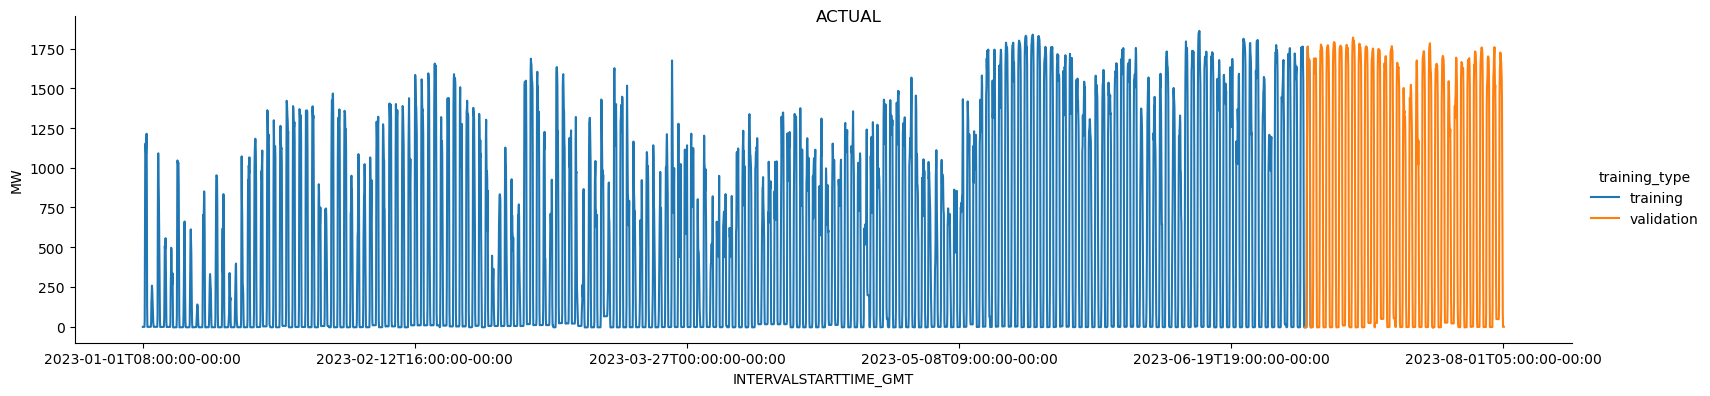

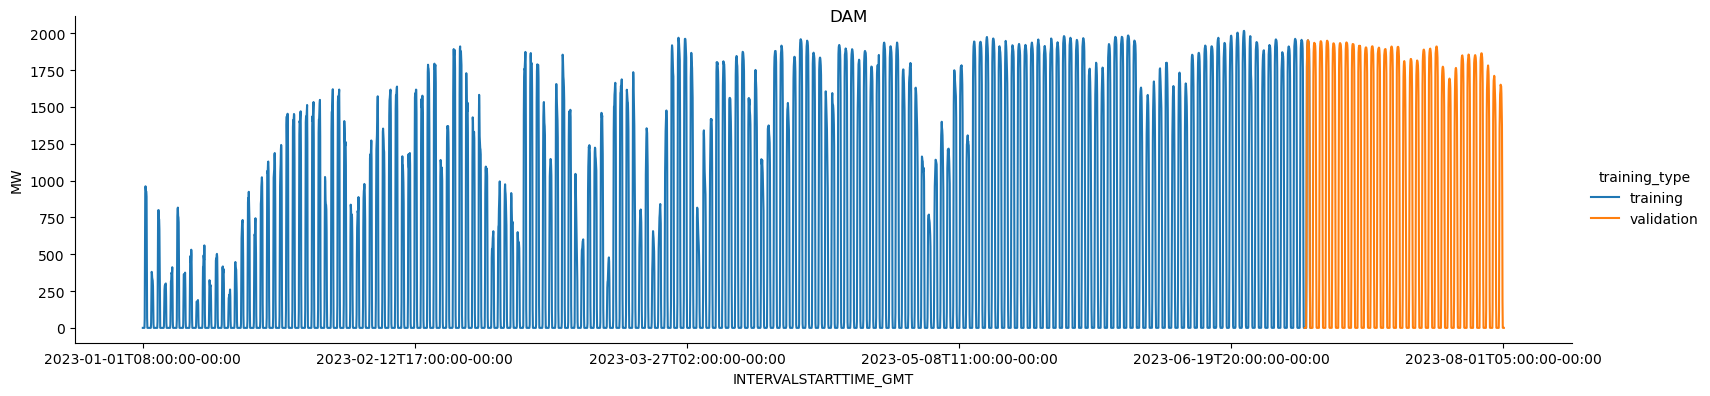

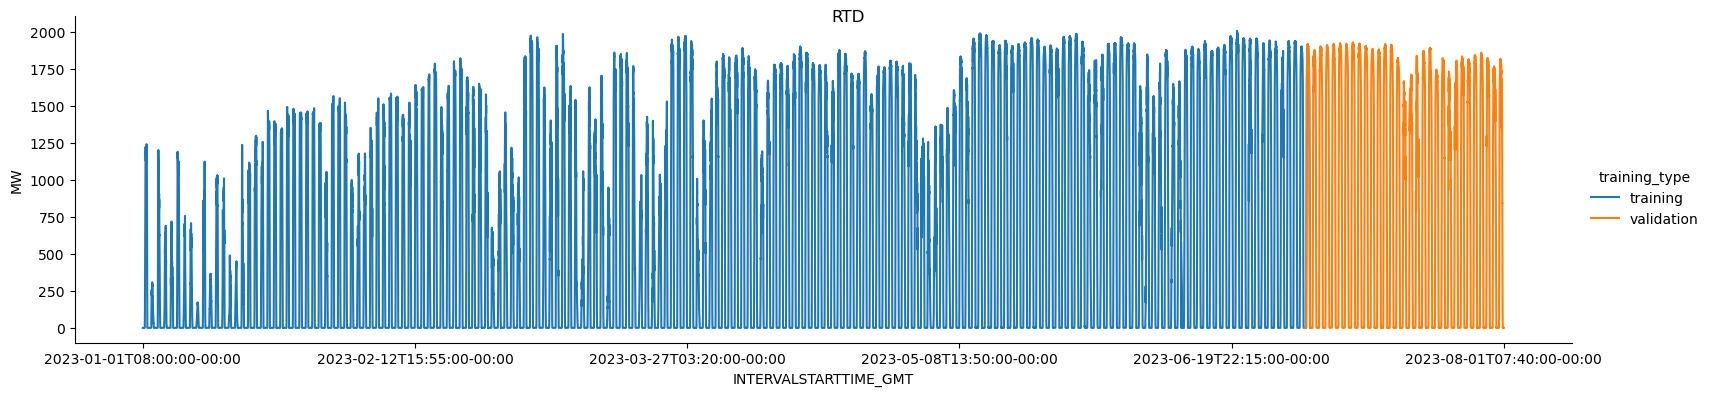

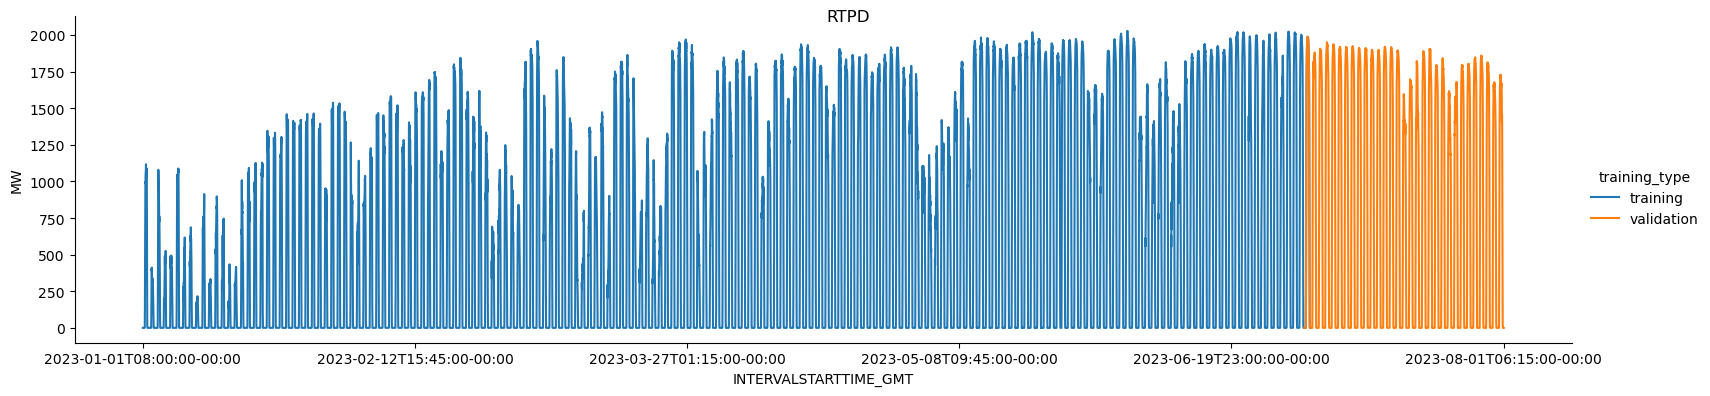

In [21]:
visualize_data()

In [22]:
def visulize_difference():
  with open("renewable.yaml") as file:
    yamlFile = yaml.safe_load(file)

  minus_visualize_id = yamlFile['minus_visualize']
  for minus_list in minus_visualize_id:
    yamlFile['market_run_id'] = minus_list[0]
    yamlFile['execution_type'] = minus_list[1]
    with open('renewable.yaml', 'w') as conf:
      yaml.dump(yamlFile, conf)
    csv = generate_data(yamlFile)
    training_set, validation_set = split_data(csv, yamlFile)
    wholedata1 = pd.concat([training_set, validation_set])
    # os.remove(csv)
    label1 = yamlFile['market_run_id'] if not yamlFile['execution_type'] else yamlFile['market_run_id']+" - "+yamlFile['execution_type']
    
    yamlFile['market_run_id'] = minus_list[2]
    yamlFile['execution_type'] = minus_list[3]
    with open('renewable.yaml', 'w') as conf:
      yaml.dump(yamlFile, conf)
    csv = generate_data(yamlFile)
    training_set, validation_set = split_data(csv, yamlFile)
    wholedata2 = pd.concat([training_set, validation_set])
    # os.remove(csv)
    label2 = yamlFile['market_run_id'] if not yamlFile['execution_type'] else yamlFile['market_run_id']+" - "+yamlFile['execution_type']
    
    wholedata = pd.merge(wholedata1, wholedata2, on='INTERVALSTARTTIME_GMT', suffixes=('_1', '_2'))
    wholedata['MW_diff'] = wholedata['MW_1'] - wholedata['MW_2']
    plot = sns.relplot(data=wholedata, x="INTERVALSTARTTIME_GMT", y="MW_diff", hue="training_type_1", kind="line", height=4, aspect=4)
    plot.fig.suptitle(label1+" minus "+label2)
    limit_display(5)

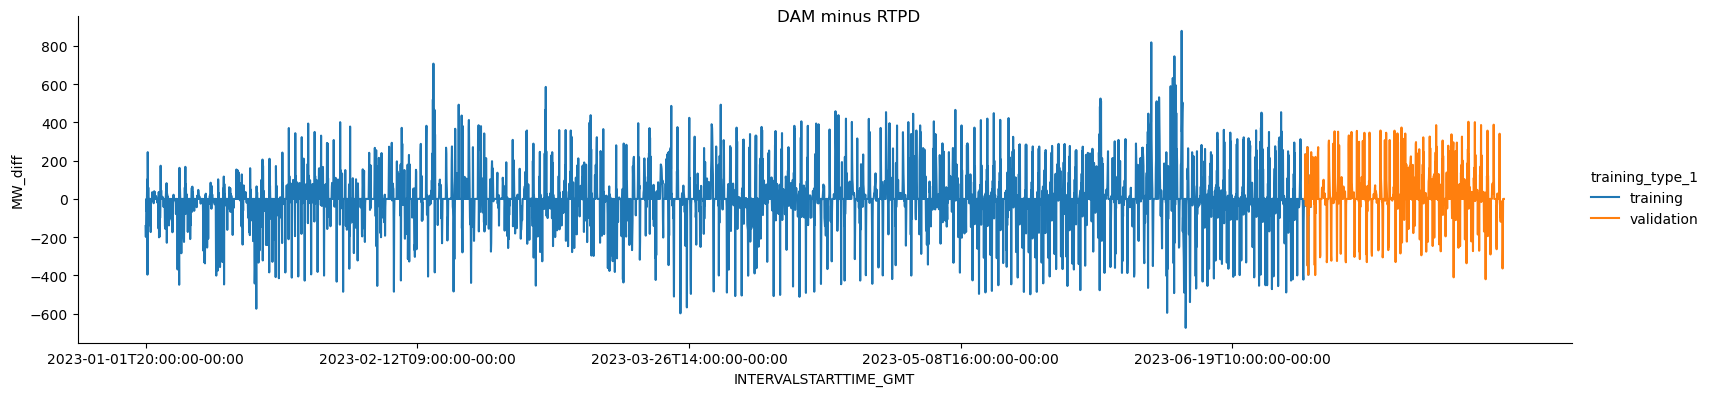

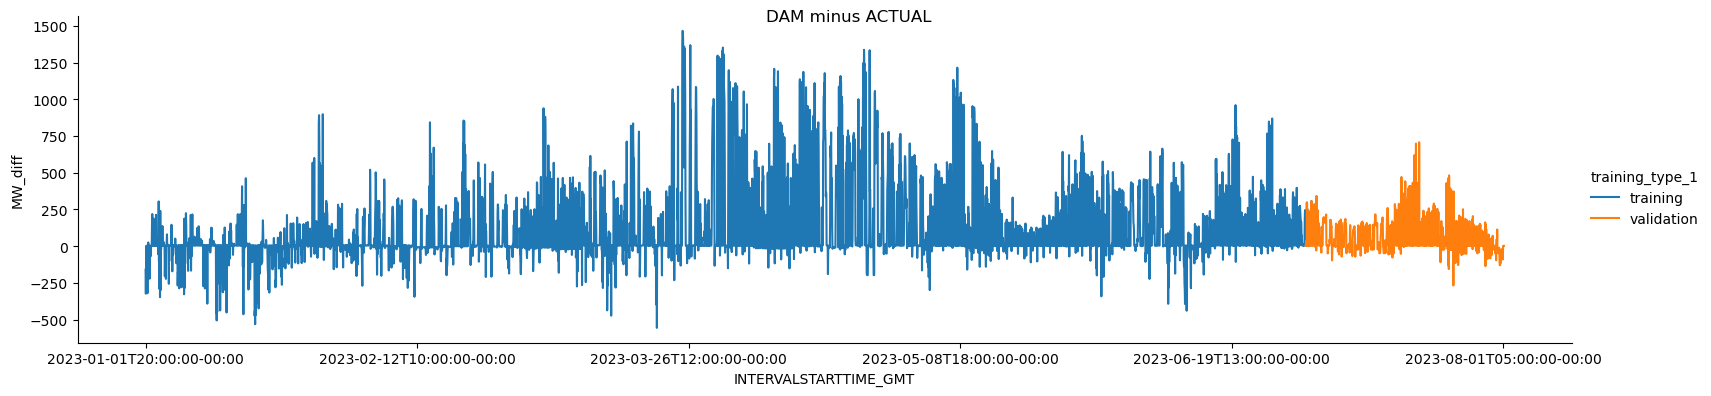

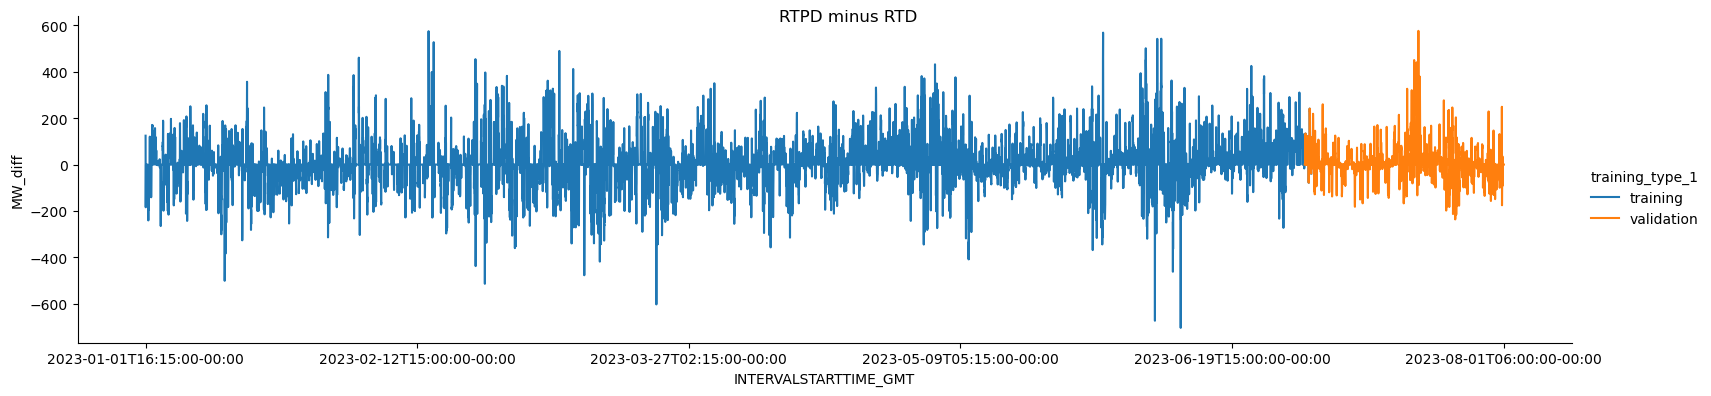

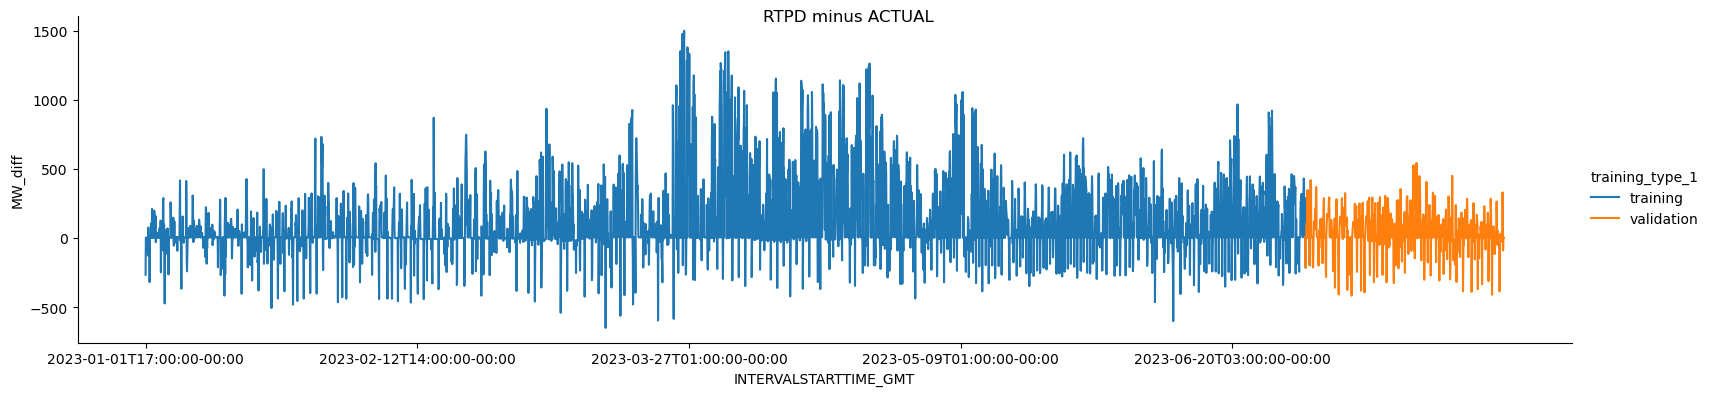

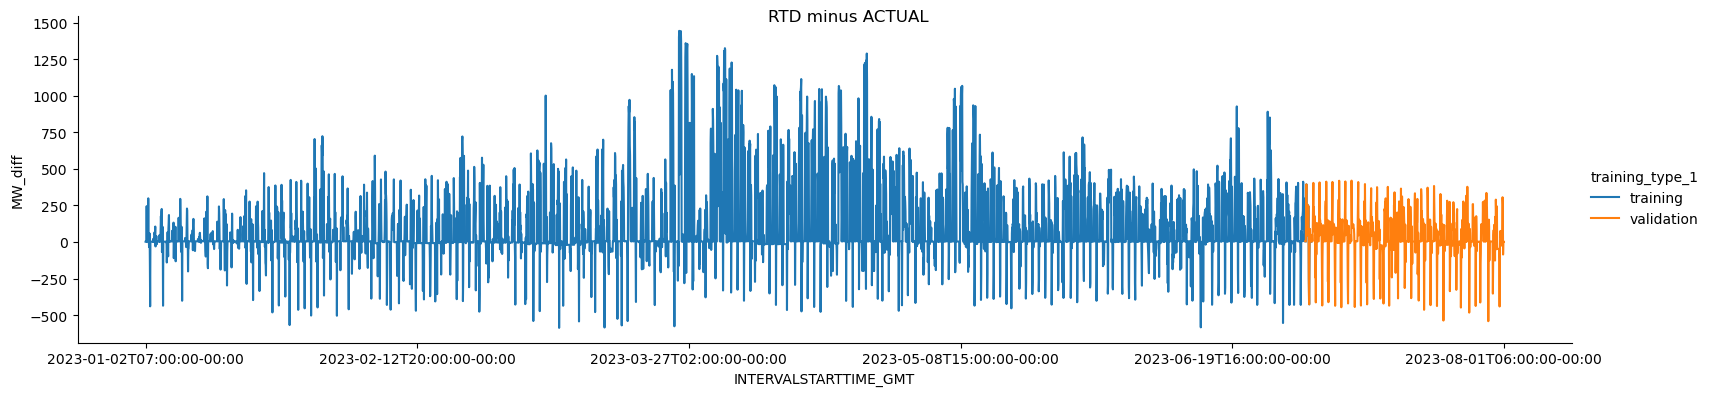

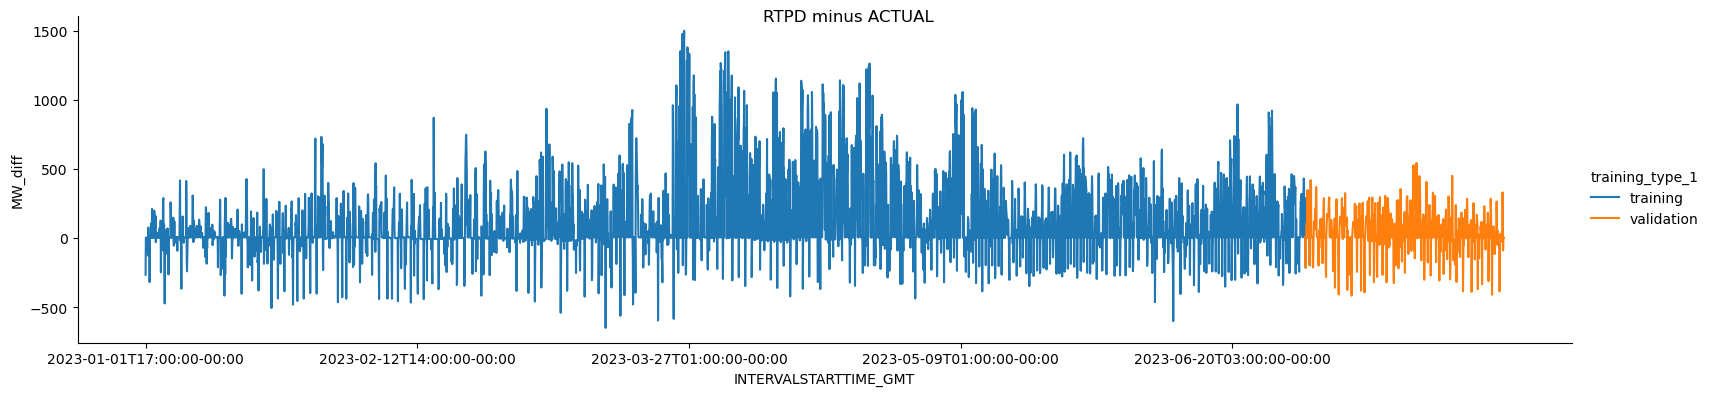

In [23]:
visulize_difference()